# Mini-projet Image : Tomographie

5GMM N - Nicolas Dublé, Valentin Fouqueau, Elizabeth Fu, Simon Treillou


La Tomographie est une technique de construction d'image d'objets 3D à partir de différentes coupes de cet objet. Différentes catégories de tomographie existent, on s'intéresse à la CT (Computerized tomography).
En CT, les différentes coupes de l'objet sont acquises par l'émission de rayons X sur l'objet à différents angles. D'un côté de l'objet on a la source d'émission de rayon X et de l'autre on a les capteurs. Dans notre cas on considère des rayons x parallèles (il en existe d'autres types).

L'idée globale est que l'acquisition de coupes de l'objet à différents angles permet de reconstruire le contour de l'objet. Dans le cas d'objet non-homogène (ex le corps humain en imagerie médicale), on aimerait acquérir la structure interne de l'objet.

Lorsqu'un rayon X traverse une matière, il perd une certaine quantité d'énergie, qui se traduit par une perte d'intensité mesurée par les capteurs. Il est assez logique aussi de comprendre que plus un matériau est dense, plus on perd d'intensité. Dans le cas d'un objet non-homogène, on aimerait capter les différentes pertes d'intensités au cours de la traversée du rayon X. Lorsqu'on projète les rayons X selon une seule projection, on ne pourra pas capter les différentes intensités au cours de la traversée, néanmoins si on combine les différentes projections (comme ce qu'on fait pour acquérir le contour de l'image, on pourra aussi acquérir la structure interne de l'objet.

(on ne considère pas l'épaisseur des rayons, on suppose qu'ils sont monochromatiques et qu'ils ne subissent pas de réfraction ou diffraction)

Un sinogramme est une représentation graphique de l'intensité perdue mesurée par les capteurs. En abscisse, l'angle theta charactéristique de la projection. En ordonnée, la distance des rayons à l'ordonnée.
Chaque point du sinogramme représente le changement en intensité selon la distance à l'origine et l'angle utilisé pour la projection.
C'est grâce au sinogramme que nous pouvons reconstruire l'objet.

La méthode de tomographie se découpe donc en 2 temps :
- acquisition des coupes de l'objet à différents angles et construction du sinogramme
- construction de l'image de la coupe à partir du sinogramme

La reconstruction tomographique peut être réalisée par 2 types de méthodes : la rétroprojection filtrée et les méthodes itératives.

ressources théorie :
- http://www.guillemet.org/irene/coursem/APRAMENrecon.pdf
- https://digitalcommons.colby.edu/cgi/viewcontent.cgi?article=1649&context=honorstheses
- Cours M. Dossal chap 5 (partie 4 Exemples)

ressources prog : 
- https://scikit-image.org/docs/stable/api/skimage.transform.html?highlight=rotation
- https://scikit-image.org/docs/0.7.0/api/skimage.transform.radon_transform.html
- https://scikit-image.org/docs/dev/auto_examples/transform/plot_radon_transform.html

## Formalisme mathématique

On considère ici un objet initial représenté sur une image $x$ de taille $L$x$C$.
On aimerait appliquer le principe de reconstruction tomographique pour reconstruire cette image.

Soit $\Theta$ la liste d'angles définies sur $[0 , 180]$. Soit $\theta$ l'angle choisi. $A$ est le nombre d'angles de la liste.

Le sinogramme de $x$ est obtenu par application d'un opérateur noté R sur l'image $x$ (en discret) ou la fonction $f$ (en continu).
L'opérateur est la transformée de Radon. Il est défini (en continu), avec la fonction $f$, l'angle $\theta$ et la position $s$ par :

$$ R(f,\theta, s) = \int_{- \inf}^{+ \inf} f(z sin \theta + s cos \theta, - z cos \theta + s sin \theta) dz $$

Il calcule l'intégrale de $f$ le long de lignes de direction $\theta$ et de position $s$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pywt
#import param
#import panel as pn

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale, rotate
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from scipy import fftpack as ft

## Image test : fantôme de Shepp-Logan

C'est une image test très répandue pour les études en tomographie. Elle est représentative d'une IRM d'une section abdominale.

dimensions de l'image :  160 160
valeurs min et max d'intensité :  0.0 1.0


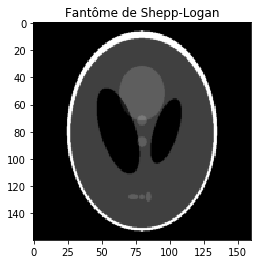

In [2]:
img = shepp_logan_phantom()
img = rescale(img, scale=0.4, mode='reflect', multichannel=False)
L,C = np.shape(img)
print("dimensions de l'image : ", L,C)
print("valeurs min et max d'intensité : ", np.min(img), np.max(img))

plt.imshow(img, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan')
plt.show()

Comme expliqué précédemment, le principe de Tomographie nécessite d'acquérir des coupes de l'image selon différents angles. Si ce sont les sources d'émissions de rayon X et les capteurs qui sont statiques, cela revient à appliquer des rotations à l'objet / l'image.

Considérons simplement le cas de l'image : par rotation, on risque de perdre de l'information aux bords. Pour réduire cette perte d'information, on fait un zéro padding sur l'image initiale.

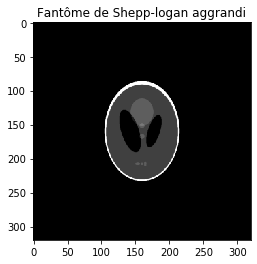

In [3]:
def zero_padding(image):
    M,N = image.shape
    res = np.zeros((M*2,N*2))
    res[int(M/2):int(M*3/2),int(N/2):int(N*3/2)] = np.copy(image)
    return res

imgz = zero_padding(img)
plt.imshow(imgz, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-logan aggrandi')
plt.show()

## Partie 1 : construction du sinogramme à partir de l'objet

Dans le cas discret, la transformée de Radon s'effectue de la sorte :
pour chaque $\theta \in \Theta$, $R_{\theta}(x)$ (transformée de Radon partielle) est un vecteur 1D de taille $L$, dont chaque valeur est la somme de chaque ligne de l'image qui a subi la rotation :
- on applique une rotation de $\theta$ à l'image x (on peut utiliser des fonctions de Python mais on verra que la rotation dépend du choix d'interpolation)
- pour chaque ligne de l'image , on fait la somme des valeurs.

Le sinogramme de $x$, $Rx$ est une matrice de taille $L$x$A$ tel que les colonnes sont $R_{\theta}(x)$.

In [4]:
def radon_transform(img, theta_list):
    R = np.zeros((np.shape(img)[0] , len(theta_list)))
    # rotation de l'image pour chaque angle
    for ind in range(len(theta_list)):
        img_rot = rotate(img, -theta_list[ind])
        R[:,ind] = sum(img_rot)
    return R

# skimage.transform.rotate() :
# interpolation spline
# paramètre optionnel : 'order' pour ordre des splines (entre 0 et 5)

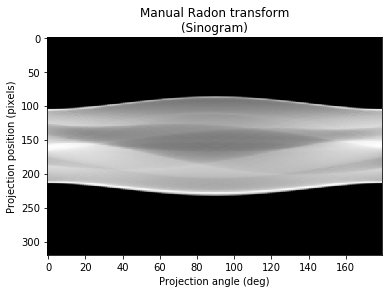

In [5]:
# test
theta_list = np.arange(180)
our_sinogram = radon_transform(imgz, theta_list)

plt.imshow(our_sinogram, cmap=plt.cm.Greys_r, aspect='auto')
plt.title("Manual Radon transform\n(Sinogram)")
plt.xlabel("Projection angle (deg)")
plt.ylabel("Projection position (pixels)")
plt.show()

Voici le sinogramme obtenu avec notre opérateur R de transformée de Radon.
Vérifions qu'il est bon en comparant avec la fonction radon() de skimage :

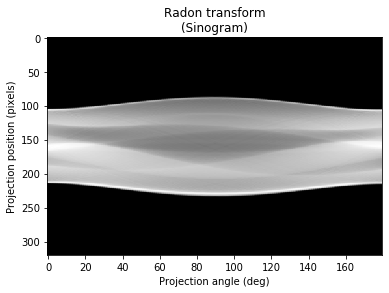

In [6]:
### vérification avec le sinogramme obtenu par radon()
sinogram_radon = radon(imgz, theta=theta_list, circle=True)

plt.imshow(sinogram_radon, cmap=plt.cm.Greys_r, aspect='auto')
plt.title("Radon transform\n(Sinogram)")
plt.xlabel("Projection angle (deg)")
plt.ylabel("Projection position (pixels)")
plt.show()

Les résultats concordent, on peu valider notre opérateur R.

## Partie 2 : reconstruire l'image à partir du sinogramme

Le sinogramme contient toutes les informations nécessaires à la reconstruction de l'image / de l'objet initial. En réalité, c'est de là que l'on part et on peut utiliser différentes méthodes :

#### • Méthode 1 : rétroprojection filtrée

#### • Méthode 2 : itératives par projection (ART)

#### • Méthode 3 : formulation variationnelle

Elles ont toutes besoin de définir l'adjoint de l'opérateur de la transformée de Radon $R$ que l'on note $R^*$. Il est défini par :

$$ R^*S = \sum_{i} R_{\theta_i}^* S_i $$

Avec $S$ le sinogramme, et $S_i$ le sinogramme partiel associé à l'angle $\theta$ 

Les 3 méthodes n'ont pas les même défauts. L'efficacité des méthodes 1 et 2 dépendant du nombre de direction (angles).

On va comparer les images reconstruites avec l'image de référence à l'aide du PSNR. Le PSNR est globalement un bon indicateur de reconstruction et est particulièrement adéquat lorsque les images de référence ont beaucoup de contraste. C'est notre cas ici.

On rappelle que la valeur max du PSNR est 100. Plus la valeur du PSNR est grande, plus l'image reconstruite est fidèle à l'image de référence.


Regardons dans un premier temps ce que l'on souhaiterait avoir. On applique la fonction iradon() de skimage au sinogramme obtenu avec radon() et au sinogramme obtenu avec notre opérateur R :

In [7]:
## fct pour remettre les valeurs de l'image entre 0 et 1
def normalize_img(img_test):
    img_test += np.abs(np.min(img_test))
    range_values = np.abs(np.max(img_test) - np.min(img_test))
    return img_test/range_values

valeurs min et max d'intensité :  0.0 1.0


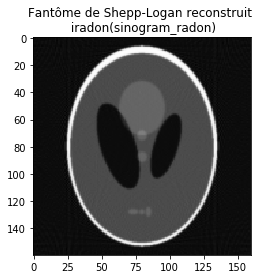

PSNR de référence :  25.842779006434323


In [11]:
### CE QU'ON SOUHAITE AVOIR :
### avec iradon()
iradon_sinogram_radon = iradon(sinogram_radon) # par défaut, filtre ramp
## crop image
crop_iradon_sinogram_radon = normalize_img(iradon_sinogram_radon[int(L/2):L+int(L/2),int(C/2):C+int(C/2)])
print("valeurs min et max d'intensité : ", np.min(crop_iradon_sinogram_radon), np.max(crop_iradon_sinogram_radon)) # on a bien remis les valeurs entre 0 et 1
plt.imshow(crop_iradon_sinogram_radon, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan reconstruit \n iradon(sinogram_radon)')
plt.show()

print("PSNR de référence : ", psnr(img, crop_iradon_sinogram_radon)) #img true, img_test

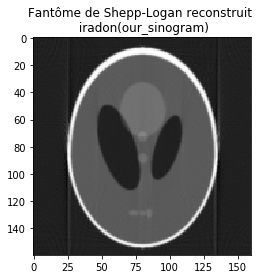

PSNR :  17.322866557986053


In [12]:
iradon_our_sinogram = iradon(our_sinogram)
crop_iradon_our_sinogram = normalize_img(iradon_our_sinogram[int(L/2):L+int(L/2),int(C/2):C+int(C/2)])

plt.imshow(crop_iradon_our_sinogram, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan reconstruit \n iradon(our_sinogram)')
plt.show()

print("PSNR : ", psnr(img, crop_iradon_our_sinogram)) #img true, img_test

Ici on a calculé le PSNR pour deux images reconstruites avec iradon() :
- une image dont le sinogramme a été calculé par skimage.transform.radon()
- une image dont le sinogramme a été calculé par nous

On voit qu'on perd presque 10 pts de PSNR avec notre sinogramme. On va voir si les méthodes de reconstruction (rétroprojection non-filtrée / filtrée, ART, variationnelle) permettent de regagner ces 10 pts.

### Méthode 1 : Rétroprojection filtrée

Il y a deux aspects de la méthode : rétroprojection et filtrage.

La rétroprojection se place dans le domaine spatial et le filtrage dans le domaine fréquentiel.
ressources :
- https://www.youtube.com/watch?v=pZ7JlXagT0w

In [13]:
def retroprojection_non_filtree(sinogram, theta_list):
    L,A = np.shape(sinogram) #320,160
    temp = np.zeros((L,L,A)) #320,320,160
    img_rec = np.zeros((L,L)) #320,320
    for index_angle in range(A):
        #print("angle numéro :", index_angle)
        tempp = np.zeros((L, L))
        # sélection de la colonne
        col = sinogram[:,index_angle]
        for index_line in range(len(col)):
            #print("valeur à copier :", col[index_line])
            tempp[index_line,:] = np.repeat(col[index_line],L)
            #print(tempp[index_line,:])
        temp[:,:,index_angle] = rotate(tempp, theta_list[index_angle])
        #plt.imshow(temp[:,:,index_angle], cmap=plt.cm.Greys_r)
        #plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée')
        #plt.show()
        img_rec += temp[:,:,index_angle]
    
    #return img_rec
    return normalize_img(rotate(img_rec, 90))

0.0 1.0


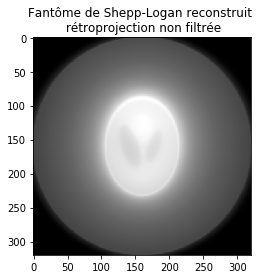

PSNR avec rétroprojection non-filtrée :  4.766616258346363


In [15]:
### test
our_img_rec = retroprojection_non_filtree(our_sinogram, theta_list)
print(np.min(our_img_rec), np.max(our_img_rec))

crop_our_img_rec = our_img_rec[int(L/2):L+int(L/2),int(C/2):C+int(C/2)]

plt.imshow(our_img_rec, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée')
plt.show()

print("PSNR avec rétroprojection non-filtrée : ", psnr(img, crop_our_img_rec)) #img true, img_test

### Test variation de méthode d'interpolation 

Au dessus, l'interpolation est bi-linéaire par défaut de la fonction rotate de skimage.transform car on a une image en niveaux de gris. Testons l'interpolation en nearest-neighbor, bi-quadratique, bi-cubique. Cela correspond à l'ordre des splines (ordre 0,2,3).

Pour un grand nombre d'angles, on ne verra pas forcément la différence entre les interpolations.
Testons les différentes interpolations sur un faible nombre d'angles entre 0 et 180°.

In [16]:
theta_list_interpol = np.arange(0,180,4)
print(len(theta_list_interpol))
our_sinogram2 = radon_transform(imgz, theta_list_interpol)

45


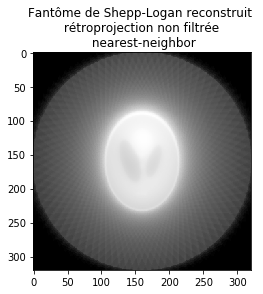

PSNR :  4.7886552741361115


In [17]:
## nearest-neighbour
def retroprojection_non_filtree(sinogram, theta_list):
    L,A = np.shape(sinogram) #320,160
    temp = np.zeros((L,L,A)) #320,320,160
    img_rec = np.zeros((L,L)) #320,320
    for index_angle in range(A):
        #print("angle numéro :", index_angle)
        tempp = np.zeros((L, L))
        # sélection de la colonne
        col = sinogram[:,index_angle]
        for index_line in range(len(col)):
            #print("valeur à copier :", col[index_line])
            tempp[index_line,:] = np.repeat(col[index_line],L)
            #print(tempp[index_line,:])
            
        temp[:,:,index_angle] = rotate(tempp, theta_list[index_angle], order = 0)
        #plt.imshow(temp[:,:,index_angle], cmap=plt.cm.Greys_r)
        #plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée')
        #plt.show()
        img_rec += temp[:,:,index_angle]
    
    #return img_rec
    return normalize_img(rotate(img_rec, 90))

### test
our_img_rec_order0 = retroprojection_non_filtree(our_sinogram2, theta_list_interpol)
crop_our_img_rec0 = our_img_rec_order0[int(L/2):L+int(L/2),int(C/2):C+int(C/2)]

plt.imshow(our_img_rec_order0, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée \n nearest-neighbor')
plt.show()

print("PSNR : ", psnr(img, crop_our_img_rec0)) #img true, img_test

/Applications/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:387: UserWarning: Bi-quadratic interpolation behavior has changed due to a bug in the implementation of scikit-image. The new version now serves as a wrapper around SciPy's interpolation functions, which itself is not verified to be a correct implementation. Until skimage's implementation is fixed, we recommend to use bi-linear or bi-cubic interpolation instead.
  mode=mode, cval=cval, clip=clip, preserve_range=preserve_range)


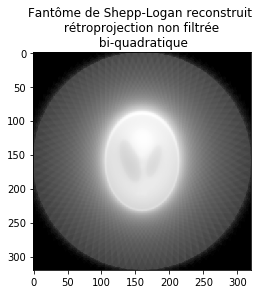

PSNR :  4.791613398299733


In [18]:
## bi-quadratique
def retroprojection_non_filtree(sinogram, theta_list):
    L,A = np.shape(sinogram) #320,160
    temp = np.zeros((L,L,A)) #320,320,160
    img_rec = np.zeros((L,L)) #320,320
    for index_angle in range(A):
        #print("angle numéro :", index_angle)
        tempp = np.zeros((L, L))
        # sélection de la colonne
        col = sinogram[:,index_angle]
        for index_line in range(len(col)):
            #print("valeur à copier :", col[index_line])
            tempp[index_line,:] = np.repeat(col[index_line],L)
            #print(tempp[index_line,:])
            
        temp[:,:,index_angle] = rotate(tempp, theta_list[index_angle], order = 2)
        #plt.imshow(temp[:,:,index_angle], cmap=plt.cm.Greys_r)
        #plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée')
        #plt.show()
        img_rec += temp[:,:,index_angle]
    
    #return img_rec
    return normalize_img(rotate(img_rec, 90))

### test
our_img_rec_order2 = retroprojection_non_filtree(our_sinogram2, theta_list_interpol)
crop_our_img_rec2 = our_img_rec_order2[int(L/2):L+int(L/2),int(C/2):C+int(C/2)]

plt.imshow(our_img_rec_order2, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée \n bi-quadratique')
plt.show()
print("PSNR : ", psnr(img, crop_our_img_rec2)) #img true, img_test

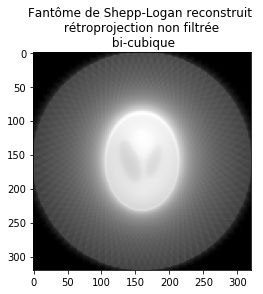

PSNR :  4.793035509424411


In [19]:
## bi-cubique
def retroprojection_non_filtree(sinogram, theta_list):
    L,A = np.shape(sinogram) #320,160
    temp = np.zeros((L,L,A)) #320,320,160
    img_rec = np.zeros((L,L)) #320,320
    for index_angle in range(A):
        #print("angle numéro :", index_angle)
        tempp = np.zeros((L, L))
        # sélection de la colonne
        col = sinogram[:,index_angle]
        for index_line in range(len(col)):
            #print("valeur à copier :", col[index_line])
            tempp[index_line,:] = np.repeat(col[index_line],L)
            #print(tempp[index_line,:])
        temp[:,:,index_angle] = rotate(tempp, theta_list[index_angle], order = 3)
        #plt.imshow(temp[:,:,index_angle], cmap=plt.cm.Greys_r)
        #plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée')
        #plt.show()
        img_rec += temp[:,:,index_angle]
    
    #return img_rec
    return normalize_img(rotate(img_rec, 90))

### test
our_img_rec_order3 = retroprojection_non_filtree(our_sinogram2, theta_list_interpol)
crop_our_img_rec3 = our_img_rec_order3[int(L/2):L+int(L/2),int(C/2):C+int(C/2)]

plt.imshow(our_img_rec_order3, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée \n bi-cubique')
plt.show()
print("PSNR : ", psnr(img, crop_our_img_rec3)) #img true, img_test

Le problème de la rétroprojection non-filtrée est de créer un halo autour du fantôme de Shepp-Logan qui pollue l'image. On voit que la valeur du PSNR est très basse à cause du halo...
La simple rétroprojection n'est définitivement pas une bonne méthode de reconstruction.

Pour un faible nombre d'angles, on voit la différence entre les différentes méthodes d'interpolation. Ici, pour 45 angles, l'interpolation par nearest-neighbour ne permet pas du tout de reconstruire l'image fidèlement. Avec bilinéaire et bicubique on obtient une meilleure approximation que l'ordre 1, mais la valeur n'augmente pas non plus beaucoup car le halo est toujours créé...

### Rétroprojection filtrée
- https://www.hindawi.com/journals/ijbi/2011/693795/
- https://www.youtube.com/watch?v=pZ7JlXagT0w

Avec la rétroprojection simple, les basses fréquences sont beaucoup plus extraites que les hautes fréquences. Les hautes fréquences sont celles qui donnent les détails d'une image.
Ici on voit ce problème par la création du halo.

L'opération de filtrage de la rétroprojection filtrée permet donc de filtrer certaines basses fréquences et laisser passer les hautes fréquences pour enlever le halo, augmenter la définition et les contours de l'image.

C'est une opération qui s'effectue dans le domaine des fréquences, et s'applique sur le sinogramme. Ainsi, on applique d'abord une transformée de Fourier au sinogramme. Pour cela, on applique une transformée de Fourier 1D sur chaque projection du sinogramme, puis on multiplie par notre filtre.

On repasse dans le domaine spatial en faisant une transformée inverse de Fourier, puis on peut appliquer la rétroprojection simple.

L'image reconstruite doit être bien meilleure qu'en rétroprojection simple.

Filtres passe-haut :
- rampe
- rampe adoucie

A l'inverse, les filtres passe-bas vont enlever le bruit (véhiculés par les hautes fréquences) mais ne vont pas garder les contours.
- butterworth
- hanning
- hamming
- shepp logan

Aucun filtre n'est parfait, le choix du filtre se fait en général empiriquement, ou selon les connaissances a priori sur le signal.

In [21]:
def filtrage(sinogram,filtre,theta_list):
    T,A = sinogram.shape #Taille image, nb d'angles
    res = sinogram*0.
    for j in range(A): #colonnes = angles
        four = ft.fft(sinogram[:,j])
        res[:,j] = np.real(ft.ifft(four*filtre(T)))
    return res

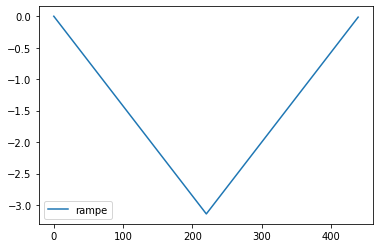

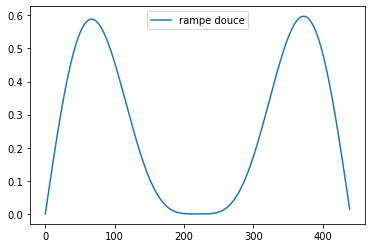

In [22]:
## plot avec le code de Simon
def rampe(T):
    step = 2*np.pi/T
    w = np.arange(-np.pi,np.pi,step)
    r = abs(w) # approx filtre rampe
    filt = ft.fftshift(r)
    return filt

plt.plot(-rampe(T=440), label="rampe")
plt.legend()
plt.show()

def rampe_adoucie(T):
    a=1 # param d'adoucissage (a=0 non adouci, a=1 adouci)
    step = 2*np.pi/T
    w = np.arange(-np.pi, np.pi, step)
    rn1 = abs(w)  # filtre rampe
    rn2 = a*np.hanning(T)  #sinc window with 'a' modifying the cutoff freqs
    r = rn1*(rn2)**2             #modulation of ramp filter with sinc window
    filt = ft.fftshift(r) 
    return filt

plt.plot(rampe_adoucie(T=440), label="rampe douce")

plt.legend()
plt.show()

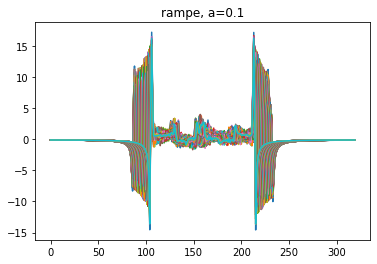

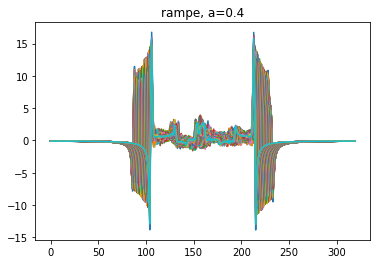

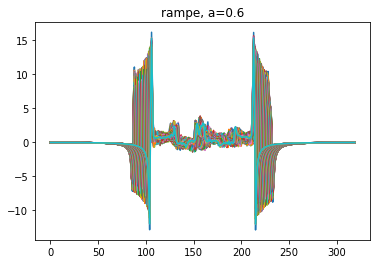

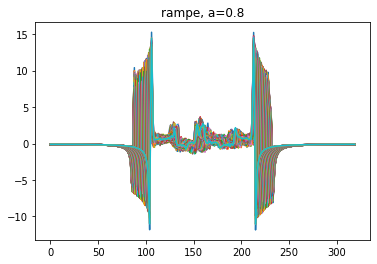

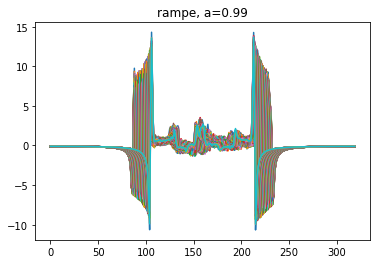

In [23]:
## code zaza
def arange2(start, stop=None, step=1):
    """#Modified version of numpy.arange which corrects error associated with non-integer step size"""
    if stop == None:
        a = np.arange(start)
    else: 
        a = np.arange(start, stop, step)
        if a[-1] > stop-step:   
            a = np.delete(a, -1)
    return a

def rampe_zaza(sinogram, a):
    T,A = np.shape(sinogram)
    ## paramètre a : permet d'adoucir la rampe (a proche de 1) ou rampe pure (a proche de 0)
    step = 2*np.pi/T
    w = arange2(-np.pi, np.pi, step)
    if len(w) < T:
        w = np.concatenate([w, [w[-1]+step]]) #depending on image size, it might be that len(w) =  
                                              #projLen - 1. Another element is added to w in this case
    rn1 = abs(2/a*np.sin(a*w/2));  #approximation of ramp filter abs(w) with a funciton abs(sin(w))
    rn2 = np.sin(a*w/2)/(a*w/2);   #sinc window with 'a' modifying the cutoff freqs
    r = rn1*(rn2)**2;              #modulation of ramp filter with sinc window
    
    filt = ft.fftshift(r)   
    filtSino = np.zeros((T, A))
    for i in range(A):
        projfft = ft.fft(sinogram[:,i])
        filtProj = projfft*filt
        filtSino[:,i] = np.real(ft.ifft(filtProj))
        
    return np.array(filtSino)

#print(np.shape(rampe_zaza(our_sinogram)))
for a in [0.1,0.4,0.6,0.8,0.99]:
    plt.figure()
    plt.plot(rampe_zaza(our_sinogram,a), label="rampe")
    plt.title("rampe, a={}".format(a))

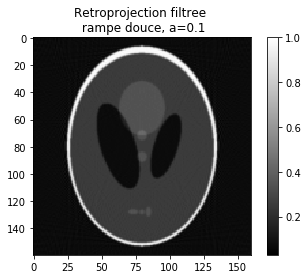

PSNR :  23.053222676062127


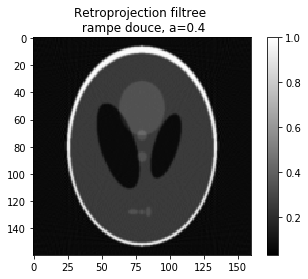

PSNR :  23.026144671753713


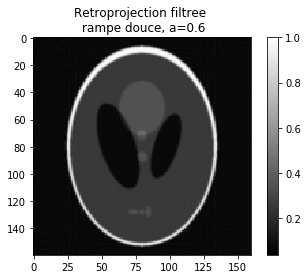

PSNR :  23.023697618886114


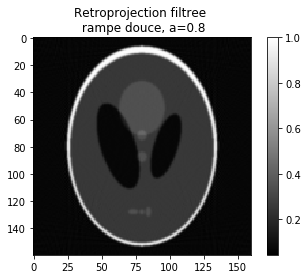

PSNR :  22.93183038005342


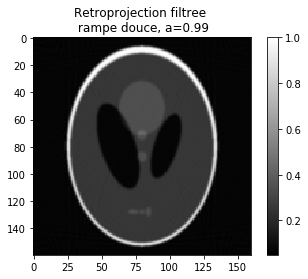

PSNR :  22.786139768484972


In [25]:
#sinoFilt_zaza = filtrage_zaza(our_sinogram,rampe_zaza,theta_list)
for a in [0.1,0.4,0.6,0.8,0.99]:
    plt.figure()
    sinoFilt_zaza = rampe_zaza(our_sinogram, a)
    imrec_rampezaza = retroprojection_non_filtree(sinoFilt_zaza, theta_list)
    crop_imrec_rampezaza = imrec_rampezaza[int(L/2):L+int(L/2),int(C/2):C+int(C/2)]

    plt.imshow(crop_imrec_rampezaza,cmap='gray')
    plt.title("Retroprojection filtree \n rampe douce, a={}".format(a))
    plt.colorbar()
    plt.show()

    print("PSNR : ", psnr(img, crop_imrec_rampezaza)) #img true, img_test

Normalement, on doit avoir une meilleure reconstruction avec la rampe douce (avec a proche de 1) qu'avec la rampe pure, mais ici on observe l'inverse.

## Méthode 3 : Formulation variationnelle

### Régularisation par seuillage doux en base d'ondelettes : l'algorithme Forward-Backward

On veut minimiser la fonction $F$ telle que :

$$F(x)=\frac{1}{2} \|y-Rx\|_2^2+\lambda\|T x\|_1$$

avec $T$ une transformée orthogonale en ondelettes telle que $Tx$ soit sparse.

Opérateur $R$ = transformée de Radon

Opérateur $R^*$ = rétroprojection non-filtrée

In [26]:
## Radon transform: from image to sinogram
def R(image,N=100):
    theta = np.linspace(0,180,N)
    return radon(image,theta,circle=False)

## Adjoint of Radon transform: from sinogram to image using backpropagation (unfiltered or not)
def R_star(sin,filt=None,inter='cubic'):
    T,A = sin.shape
    theta = np.linspace(0,180,A)
    return iradon(sin,theta,filter=filt,interpolation=inter,circle=False)

Opérateur $T$ = seuillage par ondelettes

In [27]:
def SeuillageDouxOndelettes(I,wave,Seuil):
    L=pywt.dwt_max_level(len(I),pywt.Wavelet(wave).dec_len)
    wavelet_coeffs= pywt.wavedecn(I, wave, mode='per', level=L)
    arr, coeff_slices, coeff_shapes = pywt.ravel_coeffs(wavelet_coeffs)
    temp=pywt.threshold(arr,Seuil,mode='soft')
    test=pywt.unravel_coeffs(temp, coeff_slices, coeff_shapes, output_format='wavedecn')
    Irec=pywt.waverecn(test, wave,mode='per')
    return Irec

Opérateur proximal de $T$

In [28]:
def Normel1Ondelettes(I,wave):
    L=pywt.dwt_max_level(len(I),pywt.Wavelet(wave).dec_len)
    wavelet_coeffs= pywt.wavedecn(I, wave, mode='per', level=L)  # T
    arr, coeff_slices, coeff_shapes = pywt.ravel_coeffs(wavelet_coeffs)
    norml1=sum(np.abs(arr)) # norm
    return norml1

Fonction à minimiser $F$

In [29]:
def Function(x,y,lam,wave,N):
    return lam*Normel1Ondelettes(x,wave) + 0.5*(np.linalg.norm(R(x,N)-y,2)**2)

Gradient de $F$

In [30]:
def Gradient(x,b,N):
    return R_star(R(x,N))- R_star(b)

Algorithme de Forward-Backward

In [31]:
def ForwardBackward(y,x0,step,lam,Niter,wave,N=50,tol=0.0001,f=Function):
    seuil=lam*step
    x=x0  # Initialisation via retroprojection non-filtrée
    F=[]
    nfin = Niter
    conv = []
    for n in range(Niter):
        #print("Iter n°",n)
        I = x-step*Gradient(x,y,N)
        T = SeuillageDouxOndelettes(I, wave, seuil)
        if n==-1:
            err = np.linalg.norm(T-x)#/np.linalg.norm(x)
        else:
            err = np.linalg.norm(T-x)/np.linalg.norm(x)
        conv.append(err)
        x = np.copy(T)
        F +=  [f(x,y,lam,wave,N)]
        #print("err : ", err,'\n')
        if err<=tol:
            nfin = n
            found = True
            break
    return x,np.array(F), np.array(conv[1:]), nfin

In [33]:
N = 30
y = R(img,N)
lam = 1
wave = 'db4'
imgb = R_star(y)
imgfb = R_star(y,'ramp')
x0 = imgb
step = 0.005
Niter = 100
imgv,F,conv, itert = ForwardBackward(y,x0,step,lam,Niter,wave,N=N)

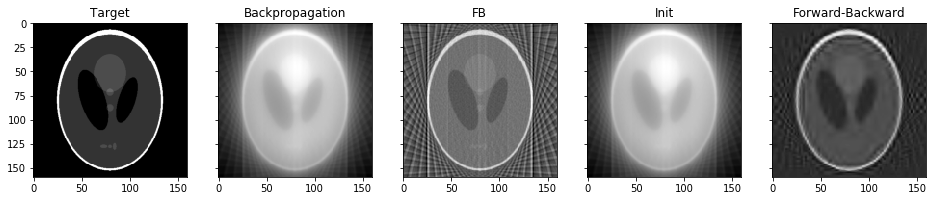

In [34]:
fig, axs = plt.subplots(1, 5, figsize=(16, 3), sharey=True)
axs[0].imshow(img,cmap='gray')
axs[0].set_title('Target')
axs[1].imshow(imgb,cmap='gray')
axs[1].set_title('Backpropagation')
axs[2].imshow(imgfb,cmap='gray')
axs[2].set_title('FB')
axs[3].imshow(x0,cmap='gray')
axs[3].set_title('Init')
axs[4].imshow(imgv,cmap='gray')
axs[4].set_title('Forward-Backward')
plt.show()

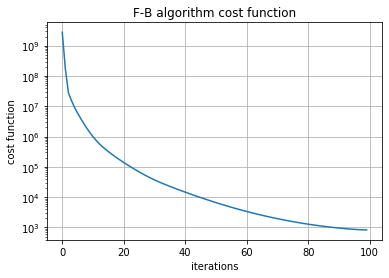

In [35]:
plt.plot(F)
plt.yscale('log')
plt.title('F-B algorithm cost function')
plt.xlabel('iterations')
plt.grid()
plt.ylabel("cost function")
plt.show()

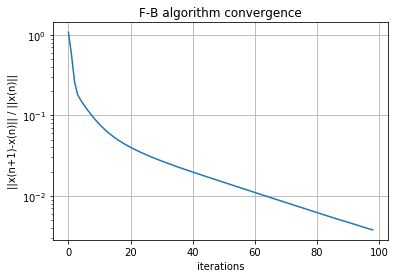

In [36]:
plt.plot(conv)
plt.yscale('log')
plt.title('F-B algorithm convergence')
plt.xlabel('iterations')
plt.grid()
plt.ylabel("||x(n+1)-x(n)|| / ||x(n)||")
plt.show()

In [38]:
#print("PSNR backpropagation          : ", psnr(img,imgb))
print("PSNR filtered backpropagation : ", psnr(img,imgfb))
print("PSNR variational method       : ", psnr(img,imgv),'\n')
print("MSE backpropagation          : ", mse(imgb,img))
print("MSE filtered backpropagation : ", mse(imgfb,img))
print("MSE variational method     : ",mse(imgv,img))

PSNR filtered backpropagation :  17.817088883659753
PSNR variational method       :  23.272551995061676 

MSE backpropagation          :  1046.7533776530006
MSE filtered backpropagation :  0.016530694948085078
MSE variational method     :  0.0047070065266711664


In [41]:
N = 30
y = R(img,N)
lam = 1
wave = 'db4'
imgb = R_star(y)
imgfb = R_star(y,'ramp')
x0 = imgb
step = 0.005
Niter = 100
imgv,F,conv, itert = ForwardBackward(y,x0,step,lam,Niter,wave,N=N)

In [42]:
lam = 1
wave = 'db4'
step = 0.005
Niter = 100
proj_list = [5,10,15,20,30,40,50,60,70,80,90,100]
psnr_fb = []
psnr_v = []
for i in proj_list:
    print('#################################')
    print('N = ',i)
    y = R(img,i)
    imgb = R_star(y)
    imgfb = R_star(y,'ramp')
    x0 = imgb
    imgv,F,conv,itert = ForwardBackward(y,x0,step,lam,Niter,wave,N=i)
    psnr_fb.append(psnr(img,imgfb))
    psnr_v.append(psnr(img,imgv))
    print("PSNR Filtered backpropagation: ",psnr_fb[-1])
    print("PSNR Forward-Backward        : ",psnr_v[-1])
    print('#################################\n')

#################################
N =  5
PSNR Filtered backpropagation:  3.891481726589138
PSNR Forward-Backward        :  16.07506978299139
#################################

#################################
N =  10
PSNR Filtered backpropagation:  9.063426416919286
PSNR Forward-Backward        :  17.8706508466723
#################################

#################################
N =  15
PSNR Filtered backpropagation:  11.982712662945342
PSNR Forward-Backward        :  19.47474484058499
#################################

#################################
N =  20
PSNR Filtered backpropagation:  14.3154814077478
PSNR Forward-Backward        :  20.83268293303071
#################################

#################################
N =  30
PSNR Filtered backpropagation:  17.817088883659753
PSNR Forward-Backward        :  23.272551995061676
#################################

#################################
N =  40
PSNR Filtered backpropagation:  20.738102203853618
PSNR Forward-Backward 

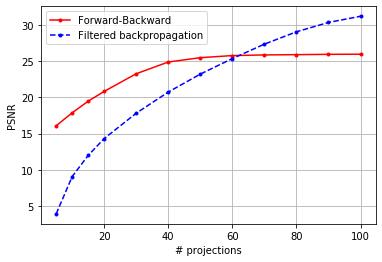

In [139]:
plt.plot(proj_list,psnr_v,label='Forward-Backward',linestyle='-',marker='.',c='red')
plt.plot(proj_list,psnr_fb,label='Filtered backpropagation',linestyle='--',c='blue',marker='.')
plt.grid()
plt.ylabel('PSNR')
plt.xlabel('# projections')
plt.title('')
plt.legend()
plt.show()

commentaires

### Régularisation avec le gradient : l'algorithme proximal-dual de Condat

Condat Algorithm aims at finding $x \in E$ minimizing:
\begin{equation}
F(x) = f(x) + g(x) + \sum_{m=1}^M h_m(L_mx)
\end{equation}

where $f$ is a differentiable function which gradient is L-Lipschitz and functions $g$ and $h_m$ have known *proximity operators* and $L_m$ are linear operators.

In [140]:
#taken from PoissonEditing TP
def GradientHor(x):
    y=x-np.roll(x,1,axis=1)
    y[:,0]=0
    return y
def GradientVer(x):
    y=x-np.roll(x,1,axis=0)
    y[0,:]=0
    return y
def DivHor(x):
    N=len(x[0])
    y=x-np.roll(x,-1,axis=1)
    y[:,0]=-x[:,1]
    y[:,N-1]=x[:,N-1]
    return y
def DivVer(x):
    N=len(x)
    y=x-np.roll(x,-1,axis=0)
    y[0,:]=-x[1,:]
    y[N-1,:]=x[N-1,:]
    return y
def Gradient(x):
    y=[]
    y.append(GradientHor(x))
    y.append(GradientVer(x))
    return np.array(y)
def Div(y):
    x=DivHor(y[0,:])+DivVer(y[1,:])
    return x

In [141]:
# define F (function to be minimized)
def F(y,x,lam,N=100):
    return np.sum((y-R(x,N))**2)/2+lam*np.sum(np.abs(Gradient(x)))

# define grad of f
def grad_f(y,x,N=100):
    return R_star(R(x,N)-y) #you can choose one of the 2 expressions, depending on what is easier and more efficient to implement
    #return R_star(y)-R_star_R(x) #R_star_R(x) stands for R_star(R(x))

# define sum of L* of u
def sum_L_m_star(u):
    return Div(u)

# define l_m(x):
def L_m(x):
    return Gradient(x)
    
#define prox of sigma.h*
def prox_h_star(sigma,u):
    #from Moreau's identity: prox sigma h* = Id - prox sigma h
    return u-np.sign(u)*np.maximum(0,np.abs(u)-sigma)

In [142]:
def Condat(y,lam,rho,tau,sigma,x0,u0,N=100,maxit=10,tol=0.01):
    x = np.copy(x0) #initial point
    u = np.copy(u0) #initial dual variables
    fun = [F(y,x,lam,N)]
    conv=[]
    for k in range(maxit):
        print("iter #",k)
        tilde_x = np.copy(x-tau*grad_f(y,x,N)-tau*sum_L_m_star(u))
        x_plus_un = np.copy(rho*tilde_x +(1-rho)*x)
        tilde_u = np.copy(prox_h_star(lam*sigma,u+sigma*L_m(2*tilde_x-x)))
        u_plus_un = np.copy(rho*tilde_u+(1-rho)*u)
        print(np.linalg.norm(img-x_plus_un)/np.linalg.norm(img))
        if k==0: 
            err=np.linalg.norm(x_plus_un-x)
        else:
            err=np.linalg.norm(x_plus_un-x)/conv[0]
            print("err : ",err)
        conv.append(err)    
        x = np.copy(x_plus_un)
        u = np.copy(u_plus_un)
        fun.append(F(y,x,lam,N))
        print("F   : ",fun[-1],"\n")
        if err<=tol:
            break
        
    return x,fun,np.array(conv[1:])

In [143]:
#precise x0, y, and find constants L and sup_Lm
N = 20                           # number of projections
y = R(img,N)                     # objective sinogram
imgb = R_star(y)                 # backpropagation 
imgfb = R_star(y,'ramp')         # filtered backpropagation
x0 = imgb                        # initialisation 

In [144]:
lam = 0.0001
rho = 0.5
sigma = 100
maxit=100
tol=0.001
L = 1.        #Lipschitz constant of grad f (L = |||R*R|||)
sup_Lm = 10.  #operator norm constant of div(grad) ( = |||sum Lm*Lm|||, it should be less than 10)
tau = 0.99/(L/2+sigma*sup_Lm)
print("Lambda, sigma, tau : ", lam,sigma,tau)
imgc,fun,conv = Condat(y,lam,rho,tau,sigma,x0,Gradient(x0),N=N,maxit=maxit,tol=tol)

Lambda, sigma, tau :  0.0001 100 0.0009895052473763118
iter # 0
120.91167838854703
F   :  31540185078.25046 

iter # 1
106.76093613933546
err :  0.8799538156943618
F   :  24454286714.681957 

iter # 2
94.33858391082826
err :  0.774348529606037
F   :  18967006755.594788 

iter # 3
83.43864839714561
err :  0.6814486925135734
F   :  14717277369.34571 

iter # 4
73.87994864300157
err :  0.5997275506368785
F   :  11425610253.7384 

iter # 5
65.50308315068881
err :  0.527841944425326
F   :  8875662490.338337 

iter # 6
58.167769333081644
err :  0.46461023251965644
F   :  6899968086.269168 

iter # 7
51.750491481610275
err :  0.40899287340568324
F   :  5368893810.457341 

iter # 8
46.14241932598813
err :  0.36007534318626416
F   :  4182090692.860878 

iter # 9
41.24756488380004
err :  0.31705310758998284
F   :  3261877223.5434904 

iter # 10
36.981150774850654
err :  0.2792184007473721
F   :  2548117733.378211 

iter # 11
33.26816854485904
err :  0.24594859298399102
F   :  1994258084.6205661 

F   :  2664507.0948044066 

iter # 99
3.8267316241344442
err :  0.002780110945019487
F   :  2590144.7134462143 



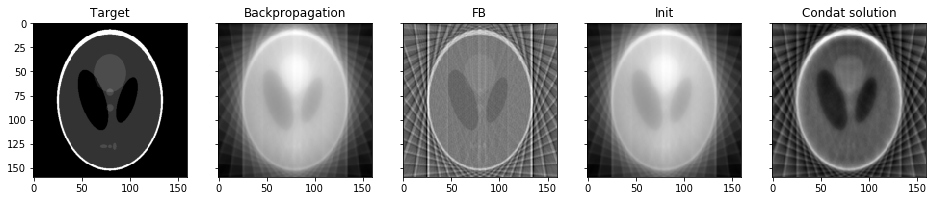

In [145]:
fig, axs = plt.subplots(1, 5, figsize=(16, 3), sharey=True)
axs[0].imshow(img,cmap='gray')
axs[0].set_title('Target')
axs[1].imshow(imgb,cmap='gray')
axs[1].set_title('Backpropagation')
axs[2].imshow(imgfb,cmap='gray')
axs[2].set_title('FB')
axs[3].imshow(x0,cmap='gray')
axs[3].set_title('Init')
axs[4].imshow(imgc,cmap='gray')
axs[4].set_title('Condat solution')
plt.show()

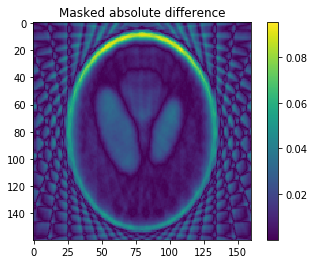

In [147]:
dif2 = (np.abs(imgc-img)/np.linalg.norm(img,1))
plt.imshow(dif2)
plt.title('Masked absolute difference')
plt.colorbar()
plt.show()

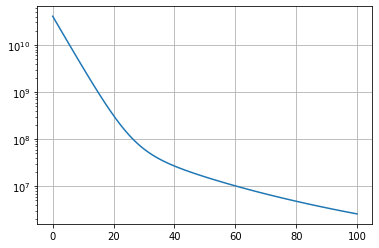

In [148]:
plt.plot(fun)
plt.yscale('log')
plt.grid()

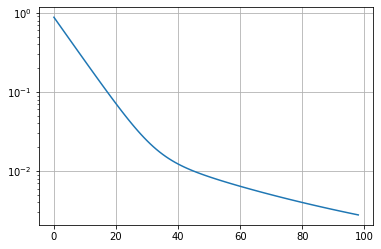

In [149]:
plt.plot(conv)
plt.yscale('log')
plt.grid()

In [151]:
print("PSNR backpropagation          : ", psnr(img,imgb))
print("PSNR filtered backpropagation : ", psnr(img,imgfb))
print("PSNR variational method       : ", psnr(img,imgc),'\n')
print("MSE backpropagation          : ", mse(imgb,img))
print("MSE filtered backpropagation : ", mse(imgfb,img))
print("MSE variational method     : ",mse(imgc,img))

PSNR backpropagation          :  -30.209262389397704
PSNR filtered backpropagation :  14.315481407747798
PSNR variational method       :  0.8701731968212189 

MSE backpropagation          :  1049.3641883298335
MSE filtered backpropagation :  0.03702131656513118
MSE variational method     :  0.8184321483756123
